In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [118]:
df = pd.read_csv('data/BA_reviews.csv')

In [119]:
df.head()

,Unnamed: 0,reviews
0,0,✅ Trip Verified | Starting off at Heathrow Te...
1,1,Not Verified | We have flown this route with ...
2,2,✅ Trip Verified | A last minute business trip ...
3,3,✅ Trip Verified | Overall I would say disapp...
4,4,Not Verified | LHR to Delhi in Business. Exce...


In [120]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [121]:
df.head()

,reviews
0,✅ Trip Verified | Starting off at Heathrow Te...
1,Not Verified | We have flown this route with ...
2,✅ Trip Verified | A last minute business trip ...
3,✅ Trip Verified | Overall I would say disapp...
4,Not Verified | LHR to Delhi in Business. Exce...


In [123]:
# Compile regular expressions for better performance
ba_regex = re.compile(r'\bBA\b', re.IGNORECASE)
british_airway_regex = re.compile(r'\bbritish\s+airway?\b', re.IGNORECASE)
british_airways_regex = re.compile(r'\bbritish\s+airways?\b', re.IGNORECASE)
flight_regex = re.compile(r'\bflight\b', re.IGNORECASE)

def clean_review(review):
    # Check if the review starts with "✅ Trip Verified"
    if review.startswith("✅ Trip Verified"):
        review_status = "verified"
        # Remove the "✅ Trip Verified" prefix
        review_text = review[len("✅ Trip Verified") + 1:].strip()
    else:
        review_status = "not verified"
        # Remove the "Not Verified" prefix
        review_text = review[len("Not Verified") + 1:].strip()
        
    # Remove special characters, emojis, and unwanted symbols
    review_text = re.sub(r'[^\w\s]', ' ', review_text)
    
    # Remove the word 'BA' (Short for British Airways)
    review_text = ba_regex.sub('', review_text)

    # Remove the word 'british airways' (for British Airways)
    review_text = british_airways_regex.sub('', review_text)

    # Remove the word 'british airway' (for British Airways)
    review_text = british_airway_regex.sub('', review_text)

    # Remove the word 'flight'
    review_text = flight_regex.sub('', review_text)
    
    # Remove extra whitespaces
    review_text = re.sub(r'\s+', ' ', review_text)
    
    # Convert to lowercase
    review_text = review_text.lower().strip()
    
    return review_status, review_text

# Apply the cleaning function to the 'reviews' column
df['review_status'], df['cleaned_reviews'] = zip(*df['reviews'].apply(clean_review))


In [124]:
df.head()

,reviews,review_status,cleaned_reviews
0,✅ Trip Verified | Starting off at Heathrow Te...,verified,starting off at heathrow terminal 3 check in w...
1,Not Verified | We have flown this route with ...,not verified,we have flown this route with easyjet regularl...
2,✅ Trip Verified | A last minute business trip ...,verified,a last minute business trip to hnd a route i r...
3,✅ Trip Verified | Overall I would say disapp...,verified,overall i would say disappointing due to statu...
4,Not Verified | LHR to Delhi in Business. Exce...,not verified,lhr to delhi in business exceptional stylish a...


In [125]:
df.drop(columns=['reviews'], inplace=True)

In [126]:
data = df.copy()

data.head()

,review_status,cleaned_reviews
0,verified,starting off at heathrow terminal 3 check in w...
1,not verified,we have flown this route with easyjet regularl...
2,verified,a last minute business trip to hnd a route i r...
3,verified,overall i would say disappointing due to statu...
4,not verified,lhr to delhi in business exceptional stylish a...


First, let us perform topic modelling, sentiment analysis and word cloud analysis on all reviews (verified and not verified)

Topics found via LDA:
Topic 1:
['london', 'airline', 'food', 'economy', 'service', 'good', 'business', 'class', 'seats', 'seat']
Topic 2:
['day', 'time', 'booked', 'cancelled', 'airport', 'told', 'london', 'service', 'customer', 'hours']
Topic 3:
['meal', 'seat', 'london', 'food', 'business', 'staff', 'class', 'service', 'cabin', 'crew']
Topic 4:
['economy', 'seats', 'cabin', 'club', 'food', 'good', 'business', 'service', 'class', 'seat']
Topic 5:
['service', 'london', 'seats', 'lounge', 'food', 'crew', 'boarding', 'check', 'good', 'time']

Overall Sentiment score is 0.07 - meaning sentiment is positive


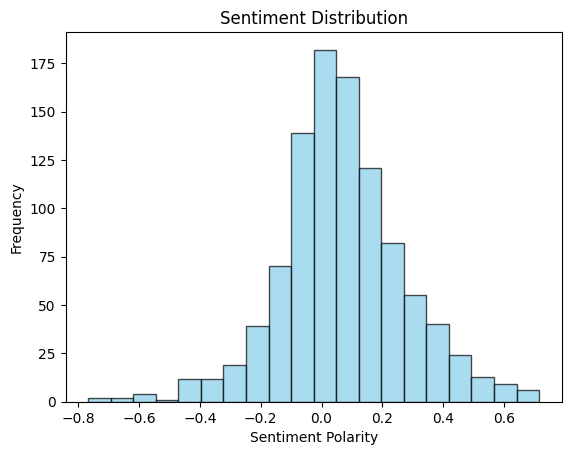

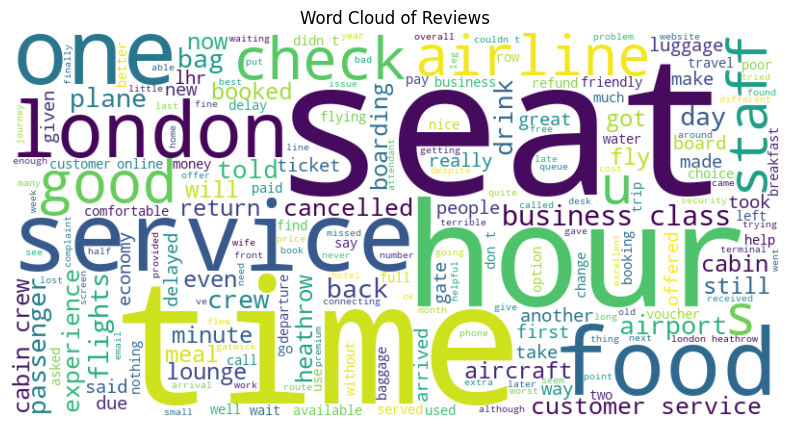

In [127]:
def review_analyzer(df):

    # Perform topic modeling
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(df['cleaned_reviews'])
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(dtm)

    # Print topics
    print("Topics found via LDA:")
    for idx, topic in enumerate(lda.components_):
        print(f"Topic {idx+1}:")
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

    # Perform sentiment analysis
    sentiment_scores = df['cleaned_reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)


    # Calculate overall sentiment score
    print(f'\nOverall Sentiment score is {sentiment_scores.mean():.2f} - meaning sentiment is {"positive" if sentiment_scores.mean() > 0 else "neutral" if sentiment_scores.mean() == 0 else "negative"}')


    # Visualize sentiment distribution
    plt.hist(sentiment_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Frequency')
    plt.show()

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_reviews']))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Reviews')
    plt.show()


review_analyzer(df)

Based on the topics found via LDA, here's an interpretation of each topic:

1. **Topic 1: Customer Service and Flight Issues**: This topic seems to focus on issues related to customer service and flight problems, including refunds, cancellations, and general dissatisfaction with the airline's service.

2. **Topic 2: Seating and Business Class**: This topic revolves around seating arrangements, particularly in business class, and the overall service provided in-flight by British Airways.

3. **Topic 3: Flight Cancellations and Delays**: This topic highlights concerns about flight cancellations, delays, and issues related to airport services, particularly at London airports.

4. **Topic 4: In-Flight Experience**: This topic seems to capture aspects of the in-flight experience, including seat comfort, cabin crew service, food quality, and overall satisfaction during the flight.

5. **Topic 5: Boarding and Luggage Handling**: This topic is centered around the boarding process, luggage handling, and staff behavior, particularly at Heathrow Airport in London.

Overall, these topics provide insights into various aspects of the customer experience with British Airways, including both positive and negative aspects such as service quality, seating comfort, flight punctuality, and airport experiences. These insights can help the airline identify areas for improvement and better understand customer preferences and pain points.


Let us now perform similar analysis of verified views, assuming these reviews will be more legit

### Analysis on Verified Reviews

Topics found via LDA:
Topic 1:
['check', 'refund', 'staff', 'class', 'business', 'london', 'customer', 'told', 'hours', 'service']
Topic 2:
['did', 'hours', 'heathrow', 'cancelled', 'london', 'airport', 'time', 'customer', 'airline', 'service']
Topic 3:
['time', 'seats', 'business', 'cabin', 'service', 'class', 'crew', 'seat', 'food', 'good']
Topic 4:
['food', 'hours', 'really', 'cabin', 'seats', 'plane', 'good', 'boarding', 'crew', 'time']
Topic 5:
['airport', 'staff', 'bag', 'service', 'said', 'heathrow', 'check', 'luggage', 'did', 'london']

Overall Sentiment score is 0.07 - meaning sentiment is positive


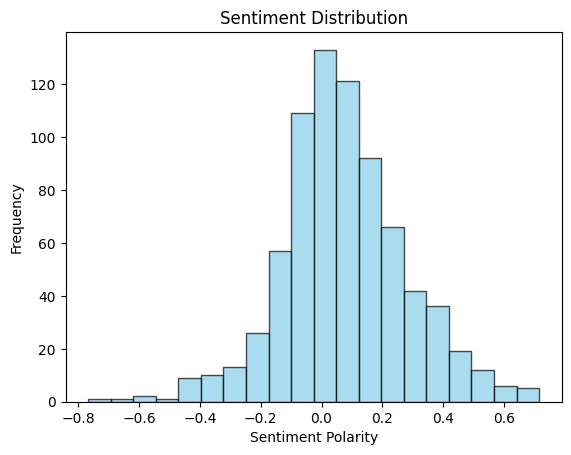

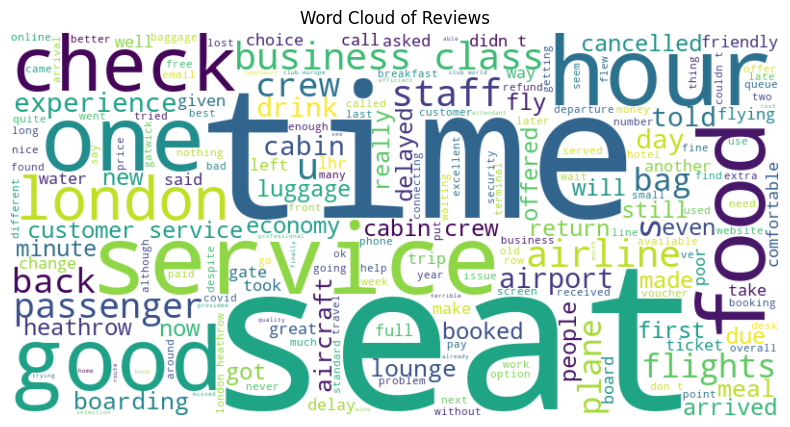

In [128]:
review_analyzer(df[df.review_status == "verified"])


### Analysis on Non-Verified Reviews

Topics found via LDA:
Topic 1:
['said', 'crew', 'customer', 'staff', 'london', 'hours', 'just', 'got', 'service', 'told']
Topic 2:
['ticket', 'class', 'hours', 'booked', 'check', 'time', 'pay', 'staff', 'business', 'service']
Topic 3:
['london', 'did', 'check', 'staff', 'hours', 'airport', 'time', 'bags', 'bag', 'luggage']
Topic 4:
['booked', 'return', 'cancelled', 'refund', 'hours', 'airline', 'travel', 'service', 'customer', 'flights']
Topic 5:
['business', 'crew', 'economy', 'london', 'time', 'seat', 'good', 'seats', 'food', 'service']

Overall Sentiment score is 0.05 - meaning sentiment is positive


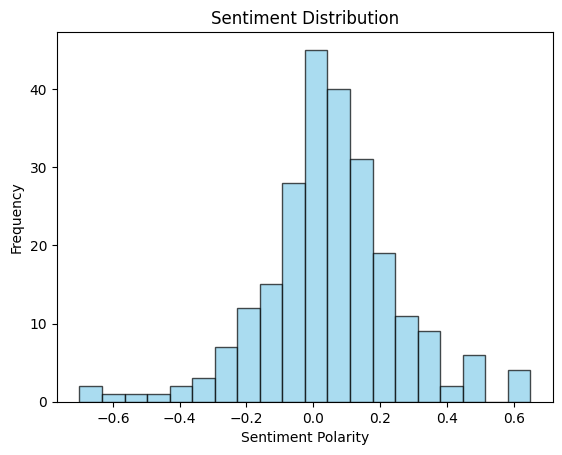

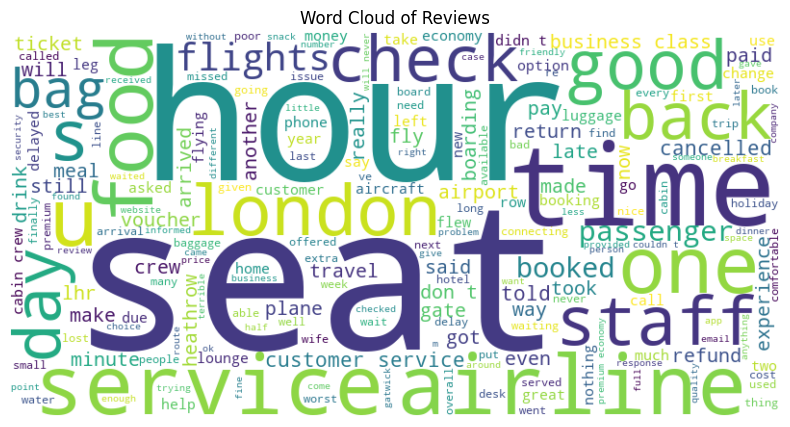

In [129]:
review_analyzer(df[df.review_status == "not verified"])